### Empiezo a desarrollar el sistema de recomiendación

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fastapi import FastAPI
from pydantic import BaseModel
import matplotlib.pyplot as plt
import seaborn as sns



In [10]:
df_movies =  pd.read_csv("df_movies_reducido.csv")
df_movies

,id,title,genres_names,release_date,budget,revenue,runtime,vote_average,vote_count,production_companies_names,original_language,release_year
0,27205,Inception,"['Action', 'Thriller', 'Science Fiction', 'Mys...",2010-07-14,160000000.0,8.255328e+08,148.0,8.1,14075.0,"['Legendary Pictures', 'Warner Bros.', 'Syncopy']",en,2010
1,155,The Dark Knight,"['Drama', 'Action', 'Crime', 'Thriller']",2008-07-16,185000000.0,1.004558e+09,152.0,8.3,12269.0,"['DC Comics', 'Legendary Pictures', 'Warner Br...",en,2008
2,19995,Avatar,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",2009-12-10,237000000.0,2.787965e+09,162.0,7.2,12114.0,"['Ingenious Film Partners', 'Twentieth Century...",en,2009
3,24428,The Avengers,"['Science Fiction', 'Action', 'Adventure']",2012-04-25,220000000.0,1.519558e+09,143.0,7.4,12000.0,"['Paramount Pictures', 'Marvel Studios']",en,2012
4,293660,Deadpool,"['Action', 'Adventure', 'Comedy']",2016-02-09,58000000.0,7.831130e+08,108.0,7.4,11444.0,"['Twentieth Century Fox Film Corporation', 'Ma...",en,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,46278,Iphigenia,"['Action', 'Drama', 'Foreign']",1977-09-10,0.0,0.000000e+00,127.0,6.6,8.0,[],el,1977
24996,48885,The Gruesome Twosome,"['Comedy', 'Horror']",1967-08-28,0.0,0.000000e+00,72.0,5.3,8.0,[],en,1967
24997,33057,Alvin Purple,['Comedy'],1973-12-20,0.0,0.000000e+00,95.0,5.4,8.0,[],en,1973
24998,45133,Sebbe,['Drama'],2010-03-12,0.0,0.000000e+00,83.0,5.9,8.0,[],sv,2010


In [11]:
df_credits =  pd.read_csv("df_credits_reducido.csv")
df_credits

,id,cast_procesado,crew_procesado
0,469172,"[{'nombre': 'Ruben de Freitas', 'personaje': '...","[{'nombre': 'Paulo Branco', 'trabajo': 'Produc..."
1,468707,"[{'nombre': 'Inka Haapamäki', 'personaje': 'Sa...","[{'nombre': 'Hannaleena Hauru', 'trabajo': 'Di..."
2,468343,[],"[{'nombre': 'Jack Witikka', 'trabajo': 'Direct..."
3,467731,"[{'nombre': 'Lloyd Bridges', 'personaje': 'Ale...","[{'nombre': 'Sidney Lumet', 'trabajo': 'Direct..."
4,465044,"[{'nombre': 'Karolina Antosik', 'personaje': '...","[{'nombre': 'Molly Smith', 'trabajo': 'Directo..."
...,...,...,...
24995,50761,"[{'nombre': 'Tony Randall', 'personaje': 'Andr...","[{'nombre': 'Harry Alan Towers', 'trabajo': 'P..."
24996,50759,"[{'nombre': 'Chishu Ryu', 'personaje': 'Shuhei...","[{'nombre': 'Yasujirō Ozu', 'trabajo': 'Screen..."
24997,50758,"[{'nombre': 'Tomás Milián', 'personaje': 'Nico...","[{'nombre': 'Bruno Corbucci', 'trabajo': 'Dire..."
24998,50754,[],"[{'nombre': 'Michael Apted', 'trabajo': 'Direc..."


## Análisis de sentimientos
Divide el rango de la columna vote_average en intervalos específicos, definidos en bins.
bins=[0, 5, 7, 10] define tres intervalos:

0 a 5: Categoría Negativo

5 a 7: Categoría Neutral

7 a 10: Categoría Positivo

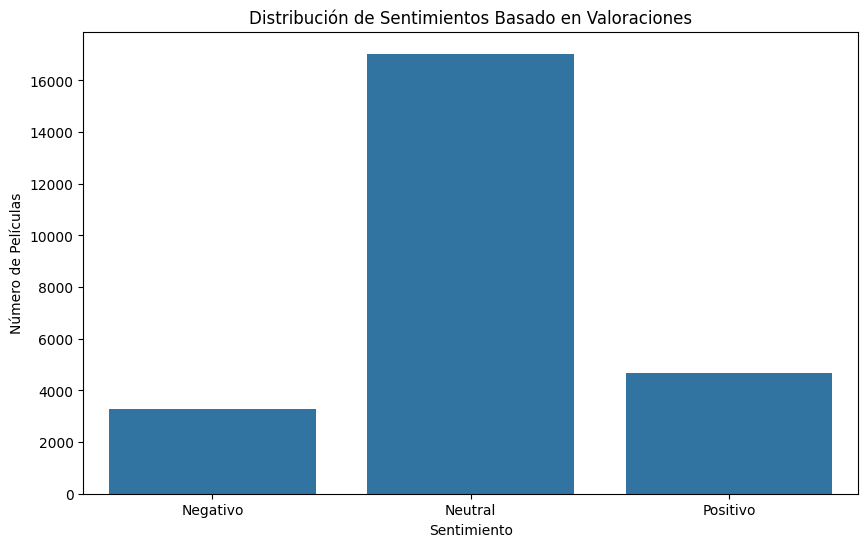

Distribución de sentimientos (%):
sentimiento
Neutral     68.2
Positivo    18.6
Negativo    13.2
Name: proportion, dtype: float64
Estadísticas de valoraciones:
Promedio: 6.15
Mediana: 6.2


In [12]:
# Crear categorías de sentimiento en base a la valoración promedio
df_movies['sentimiento'] = pd.cut(df_movies['vote_average'], 
                                  bins=[0, 5, 7, 10],
                                  labels=['Negativo', 'Neutral', 'Positivo'])

# Crear gráfico de barras para visualizar la distribución de sentimientos
plt.figure(figsize=(10, 6))
sns.countplot(data=df_movies, x='sentimiento')
plt.title('Distribución de Sentimientos Basado en Valoraciones')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Películas')
plt.show()

# Calcular y mostrar la distribución de sentimientos en porcentaje
print("Distribución de sentimientos (%):")
print(df_movies['sentimiento'].value_counts(normalize=True).round(3) * 100)

# Calcular y mostrar estadísticas básicas de las valoraciones
print("Estadísticas de valoraciones:")
print("Promedio:", round(df_movies['vote_average'].mean(), 2))
print("Mediana:", round(df_movies['vote_average'].median(), 2))


In [13]:
import pandas as pd

# Verificar las columnas para identificar la clave común
print("Columnas de df_movies:", df_movies.columns)
print("Columnas de df_credits:", df_credits.columns)

# Realizar el merge usando la columna en común (ajusta el nombre si es diferente)
df_merged = pd.merge(df_movies, df_credits, on='id', how='inner')  # usa 'id' o la columna correspondiente

# Guardar el resultado en un archivo CSV
df_merged.to_csv('df_combinado.csv', index=False)


Columnas de df_movies: Index(['id', 'title', 'genres_names', 'release_date', 'budget', 'revenue',
       'runtime', 'vote_average', 'vote_count', 'production_companies_names',
       'original_language', 'release_year', 'sentimiento'],
      dtype='object')
Columnas de df_credits: Index(['id', 'cast_procesado', 'crew_procesado'], dtype='object')


In [14]:
df =  pd.read_csv("df_combinado.csv")
df

,id,title,genres_names,release_date,budget,revenue,runtime,vote_average,vote_count,production_companies_names,original_language,release_year,sentimiento,cast_procesado,crew_procesado
0,293660,Deadpool,"['Action', 'Adventure', 'Comedy']",2016-02-09,58000000.0,783112979.0,108.0,7.4,11444.0,"['Twentieth Century Fox Film Corporation', 'Ma...",en,2016,Positivo,"[{'nombre': 'Ryan Reynolds', 'personaje': 'Wad...","[{'nombre': 'Robert Alonzo', 'trabajo': 'Stunt..."
1,157336,Interstellar,"['Adventure', 'Drama', 'Science Fiction']",2014-11-05,165000000.0,675120017.0,169.0,8.1,11187.0,"['Paramount Pictures', 'Legendary Pictures', '...",en,2014,Positivo,"[{'nombre': 'Matthew McConaughey', 'personaje'...","[{'nombre': 'Kendelle Elliott', 'trabajo': 'Ar..."
2,68718,Django Unchained,"['Drama', 'Western']",2012-12-25,100000000.0,425368238.0,165.0,7.8,10297.0,"['Columbia Pictures', 'The Weinstein Company']",en,2012,Positivo,"[{'nombre': 'Jamie Foxx', 'personaje': 'Django...","[{'nombre': 'Robert Rodriguez', 'trabajo': 'Th..."
3,118340,Guardians of the Galaxy,"['Action', 'Science Fiction', 'Adventure']",2014-07-30,170000000.0,773328629.0,121.0,7.9,10014.0,"['Marvel Studios', 'Moving Picture Company (MP...",en,2014,Positivo,"[{'nombre': 'Chris Pratt', 'personaje': 'Peter...","[{'nombre': 'Craig Wood', 'trabajo': 'Editor',..."
4,70160,The Hunger Games,"['Science Fiction', 'Adventure', 'Fantasy']",2012-03-12,75000000.0,691210692.0,142.0,6.9,9634.0,"['Lionsgate', 'Color Force']",en,2012,Neutral,"[{'nombre': 'Jennifer Lawrence', 'personaje': ...","[{'nombre': 'Debra Zane', 'trabajo': 'Casting'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9435,73208,Robbery,"['Drama', 'Crime', 'Thriller', 'Mystery']",1967-08-01,0.0,0.0,110.0,6.5,8.0,['Oakhurst Productions'],en,1967,Neutral,"[{'nombre': 'Stanley Baker', 'personaje': 'Pau...","[{'nombre': 'Peter Yates', 'trabajo': 'Directo..."
9436,343371,No Way Jose,['Comedy'],2015-06-06,0.0,0.0,98.0,4.8,8.0,"['Destination Films', 'Independent Film (USA)'...",en,2015,Negativo,"[{'nombre': 'Adam Goldberg', 'personaje': 'Jos...","[{'nombre': 'Adam Goldberg', 'trabajo': 'Direc..."
9437,85428,No. 12: Heaven and Earth Magic,['Animation'],1962-01-01,0.0,0.0,66.0,7.4,8.0,[],en,1962,Positivo,[],"[{'nombre': 'Harry Smith', 'trabajo': 'Directo..."
9438,82114,"Goodnight, Ladies and Gentlemen",['Comedy'],1976-10-28,0.0,0.0,105.0,7.1,8.0,['Cooperativa 15 Maggio'],it,1976,Positivo,"[{'nombre': 'Marcello Mastroianni', 'personaje...","[{'nombre': 'Leonardo Benvenuti', 'trabajo': '..."


In [ ]:
# Voy a calcular la similitud de coseno usando las características relevantes
from sklearn.feature_extraction.text import TfidfVectorizer

# Utilizo el vectorizador TF-IDF para convertir texto en vectores numéricos
vectorizer = TfidfVectorizer()

# Concatenamos las características de texto que queremos usar para la similitud
# Voy a usar las columnas 'genres_names', 'cast_procesado', y 'crew_procesado'
df['combined_features'] = df['genres_names'] + ' ' + df['cast_procesado'] + ' ' + df['crew_procesado']

# Convierto las características combinadas en una matriz TF-IDF
feature_matrix = vectorizer.fit_transform(df['combined_features'])

# Calculo la similitud de coseno
cosine_sim = cosine_similarity(feature_matrix)

# La matriz de similitud de coseno
print("Matriz de similitud de coseno:")
print(cosine_sim)

Matriz de similitud de coseno:
[[1.         0.73022495 0.61773473 ... 0.18269967 0.28813982 0.23261802]
 [0.73022495 1.         0.62590702 ... 0.22989495 0.2983491  0.21622857]
 [0.61773473 0.62590702 1.         ... 0.15925648 0.29701924 0.28384682]
 ...
 [0.18269967 0.22989495 0.15925648 ... 1.         0.13772587 0.0605415 ]
 [0.28813982 0.2983491  0.29701924 ... 0.13772587 1.         0.15880479]
 [0.23261802 0.21622857 0.28384682 ... 0.0605415  0.15880479 1.        ]]


In [17]:
print(df['genres_names'].unique())

["['Action', 'Adventure', 'Comedy']"
 "['Adventure', 'Drama', 'Science Fiction']" "['Drama', 'Western']" ...
 "['Action', 'Fantasy', 'Science Fiction', 'TV Movie']"
 "['Horror', 'Animation']" "['Drama', 'Crime', 'Thriller', 'Mystery']"]
